- Experiments of mnist and fashion mnist. Hyper-parameters used here is consistant with  the paper.

In [42]:
from torchvision import datasets

class DataLoader:
    def __init__(self):
        pass
    
    @classmethod
    def load(self,name):
        if name=='mnist_5':
            data=np.load('./mnist_5.npy')
            X=data[:,:-1]
            Y_true=data[:,-1]
            return X,Y_true
        
        if name=='mnist_10':
            data=np.load('./mnist_10.npy')
            X=data[:,:-1]
            Y_true=data[:,-1]
            return X,Y_true
        
        if name=='mnist_20':
            data=np.load('./mnist_20.npy')
            X=data[:,:-1]
            Y_true=data[:,-1]
            return X,Y_true
        
        if name=='mnist_30':
            data=np.load('./mnist_30.npy')
            X=data[:,:-1]
            Y_true=data[:,-1]
            return X,Y_true
        
        if name=='fmnist_5':
            data=np.load('./fmnist_5.npy')
            X=data[:,:-1]
            Y_true=data[:,-1]
            return X,Y_true
        
        if name=='fmnist_10':
            data=np.load('./fmnist_10.npy')
            X=data[:,:-1]
            Y_true=data[:,-1]
            return X,Y_true
        
        if name=='fmnist_20':
            data=np.load('./fmnist_20.npy')
            X=data[:,:-1]
            Y_true=data[:,-1]
            return X,Y_true
        
        if name=='fmnist_30':
            data=np.load('./fmnist_30.npy')
            X=data[:,:-1]
            Y_true=data[:,-1]
            return X,Y_true
        
        if name=='mnist_784':
            dataset2 = datasets.MNIST('../data', train=False, download=True)
            N=dataset2.test_data.shape[0]
            X=dataset2.test_data.numpy().reshape(N,784)/255
            Y_true=dataset2.test_labels.numpy()
            return X,Y_true

def eval_edges(Y_pred,Y_true,E_raw):
    Y_pred,Y_true=matchY(Y_pred,Y_true)
    labels=pd.DataFrame(np.hstack([Y_pred.reshape(-1,1),Y_true.reshape(-1,1),(Y_pred==Y_true).reshape(-1,1)]),columns=['y_pred','y_true','eq'])

    edges_=np.array(list(E_raw.keys()))
    pos_edges=(Y_true[edges_[:,0].astype(np.int)]==Y_true[edges_[:,1].astype(np.int)]).reshape(-1,1)
    weight=np.array(list(E_raw.values())).reshape(-1,1)

    edges=pd.DataFrame(np.hstack([edges_,weight,pos_edges]),columns=['s','t','v','pos'])

    edges=edges.sort_values(['v','s'],ascending=False)
    return labels,edges

In [2]:
import numpy as np
from scipy.optimize import linprog

def wasserstein_distance(p, q, D):
    """通过线性规划求Wasserstein距离
    p.shape=[m], q.shape=[n], D.shape=[m, n]
    p.sum()=1, q.sum()=1, p∈[0,1], q∈[0,1]
    """
    A_eq = []
    for i in range(len(p)):
        A = np.zeros_like(D)
        A[i, :] = 1
        A_eq.append(A.reshape(-1))
    for i in range(len(q)):
        A = np.zeros_like(D)
        A[:, i] = 1
        A_eq.append(A.reshape(-1))
    A_eq = np.array(A_eq)
    b_eq = np.concatenate([p, q])
    D = D.reshape(-1)
    result = linprog(D, A_eq=A_eq, b_eq=b_eq)
    return result.fun


# def wasserstein_distance(p, q):
#     """通过线性规划求Wasserstein距离
#     p.shape=[m], q.shape=[n]
#     """
#     m,n=len(p),len(q)
    
#     A_eq = []
#     for i in range(m):# sum_j(gamma_{ij})=p_i
#         A = np.zeros((m,n))
#         A[i, :] = 1
#         A_eq.append(A.reshape(-1))
    
#     for i in range(n):# sum_i(gamma_{ij})=q_j
#         A = np.zeros((m,n))
#         A[:, i] = 1
#         A_eq.append(A.reshape(-1))
        
#     A_eq = np.array(A_eq)
#     b_eq = np.concatenate([p, q])
#     c = np.ones(m*n)
#     result = linprog(c, A_eq=A_eq[:-1], b_eq=b_eq[:-1])
#     return result



def word_mover_distance(x, y):
    """WMD（Word Mover's Distance）的参考实现
    x.shape=[m,d], y.shape=[n,d]
    """
    p = np.ones(x.shape[0]) #/ x.shape[0]
    q = np.ones(y.shape[0]) #/ y.shape[0]
    D = np.sqrt(np.square(x[:, None] - y[None, :]))
    return wasserstein_distance(p, q, D)

In [10]:
edges=[(i,j,v) for (i,j),v in E_raw.items()]
edges=sorted(edges,key=lambda x:x[2],reverse=True)
F=[{i:i for i in V.keys()}]
G=[{i:[i] for i in V.keys()}]
N=[{i:len(V[i]) for i in V.keys()}]
W=[1]

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:21: OptimizeWarning:

A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.



6.922184459678946e-13

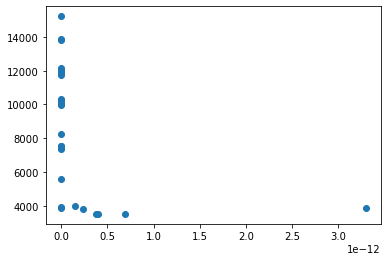

In [11]:
for i,j,w in edges:
    f_prev=F[-1]
    g_prev=G[-1]
    n_prev=N[-1]
    if f_prev[i]!=f_prev[j]:
        S_i=g_prev[i]
        S_j=g_prev[j]
        S=S_i+S_j
        
        f_now=f_prev.copy()
        for k in S_j:
            f_now[k]=f_prev[i]
        
        g_now=g_prev.copy()
        for k in S:
            g_now[k]=S
            
        n_now=n_prev.copy()
        for k in S:
            n_now[k]=n_prev[i]+n_prev[j]
        
        F.append(f_now)
        G.append(g_now)
        N.append(n_now)
        W.append(w)

seqs=[]
weights=[]
for idx in range(len(N)):
    seq = np.array(sorted([N[idx][c] for c in set(F[idx].values())],reverse=True))
    if len(seq)<10:
        break
    seqs.append(seq[:10])
    weights.append(W[idx])
    

target=np.array([1000 for i in range(10)])
score=[]
for idx in range(len(seqs)):
    score.append(word_mover_distance(seqs[idx],target))

plt.scatter(weights[1:],score[1:])

weights[np.argmin(score)]

# GDT

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys;sys.path.append('../utils/')
import imp
import plot_tools,api
import pandas as pd
import networkx as nx
from measures import matchY,measures_calculator,matchY
import time

In [63]:
X,Y_true=DataLoader.load('mnist_5')

t1=time.time()
Y_pred,V,E_raw,X_extend=api.GIT.fit(  X,
                  k=15,
                  target_ratio=[1 for i in range(10)],
                  plot=False,
                 )

t2=time.time()
print(t2-t1)
print(measures_calculator(Y_true,Y_pred))

P5=X_extend[:,-4]
# labels,edges = eval_edges(Y_pred,Y_true,E_raw)
# plt.scatter(edges['v'],edges['pos'])

2.49027681350708
         f1       ARI     ACC       NMI  cover_rate  classes
0  0.898395  0.793921  0.8898  0.812878         1.0     11.0


In [49]:
X,Y_true=DataLoader.load('mnist_10')

t1=time.time()
Y_pred,V,E_raw,X_extend=api.GIT.fit(  X,
                  k=15,
                  target_ratio=[1 for i in range(10)],
                  plot=False,
                 )

t2=time.time()
print(t2-t1)
print(measures_calculator(Y_true,Y_pred))

P10=X_extend[:,-4]

3.7549612522125244
         f1       ARI     ACC       NMI  cover_rate  classes
0  0.871581  0.746731  0.8693  0.773166         1.0     12.0


In [66]:
X,Y_true=DataLoader.load('mnist_20')

t1=time.time()
Y_pred,V,E_raw,X_extend=api.GIT.fit(  X,
                  k=15,
                  target_ratio=[1 for i in range(10)],
                  plot=False,
                 )

t2=time.time()
print(t2-t1)
print(measures_calculator(Y_true,Y_pred))

P20=X_extend[:,-4]

6.318027973175049
         f1       ARI     ACC       NMI  cover_rate  classes
0  0.856214  0.712544  0.8553  0.731779         1.0     12.0


In [68]:
X,Y_true=DataLoader.load('mnist_30')

t1=time.time()
Y_pred,V,E_raw,X_extend=api.GIT.fit(  X,
                  k=15,
                  target_ratio=[1 for i in range(10)],
                  plot=False,
                 )

t2=time.time()
print(t2-t1)
print(measures_calculator(Y_true,Y_pred))

P30=X_extend[:,-4]

7.730244874954224
         f1       ARI     ACC       NMI  cover_rate  classes
0  0.824686  0.681538  0.8019  0.725315         1.0     11.0


In [55]:
# from sklearn.decomposition import PCA
# X,Y_true=DataLoader.load('mnist_784')
# pca = PCA(n_components=30)
# pca.fit(X)
# X_ = pca.transform(X)

from sklearn import cluster
X,Y_true=DataLoader.load('mnist_784')
# agglo = cluster.FeatureAgglomeration(n_clusters=10)
# agglo.fit(X)
# X_ = agglo.transform(X)
t1=time.time()

Y_pred,V,E_raw,X_extend=api.GIT.fit(  X,
                  k=15,
                  target_ratio=[1 for i in range(10)],
                  plot=False,
                 )

t2=time.time()
print(t2-t1)
print(measures_calculator(Y_true,Y_pred))

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



16.49065327644348
         f1       ARI     ACC       NMI  cover_rate  classes
0  0.574162  0.372957  0.5749  0.480075         1.0     11.0


In [56]:
P784=X_extend[:,-4]

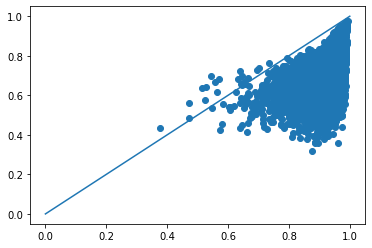

In [77]:
plt.scatter(P5,P30)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))

In [19]:
X,Y_true=DataLoader.load('mnist_784')

t1=time.time()
Y_pred,V,E_raw,X_extend=api.GIT.fit(  X,
                  k=15,
                  target_ratio=[1 for i in range(10)],
                  plot=False,
                 )

t2=time.time()
print(t2-t1)
print(measures_calculator(Y_true,Y_pred))

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:63: UserWarning:

test_data has been renamed data

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning:

test_labels has been renamed targets



16.54907774925232
         f1       ARI     ACC       NMI  cover_rate  classes
0  0.574162  0.372957  0.5749  0.480075         1.0     11.0


0.4372420310974121
         f1       ARI     ACC       NMI  cover_rate  classes
0  0.878581  0.768655  0.8593  0.786728         1.0     18.0


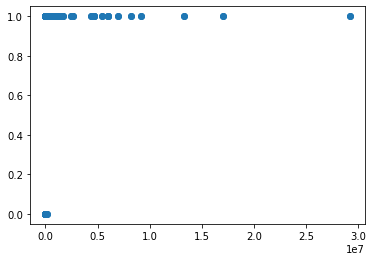

In [8]:
X,Y_true=DataLoader.load('mnist_5')

t1=time.time()
Y_pred,E_raw,V=api.DGSFC.fit(  X,
                  K_d=20,
                  K_s=20,
                  threshold=140164.7,
                  way='P_mid',
                  alpha=0,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )

t2=time.time()
print(t2-t1)
print(measures_calculator(Y_true,Y_pred))

labels,edges = eval_edges(Y_pred,Y_true,E_raw)
plt.scatter(edges['v'],edges['pos'])

0.4501223564147949
         f1       ARI     ACC       NMI  cover_rate  classes
0  0.856285  0.700572  0.8127  0.752809         1.0     29.0


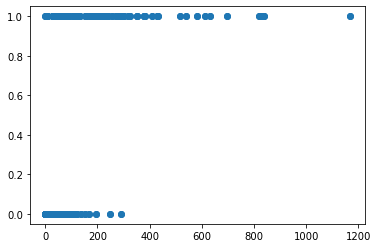

In [6]:
X,Y_true=DataLoader.load('mnist_5')

t1=time.time()
Y_pred,E_raw=api.DGSFC.fit(  X,
                  K_d=20,
                  K_s=20,
                  threshold=300,
                  way='gamma*P_mid',
                  alpha=0,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )

t2=time.time()
print(t2-t1)
print(measures_calculator(Y_true,Y_pred))

labels,edges = eval_edges(Y_pred,Y_true,E_raw)
plt.scatter(edges['v'],edges['pos'])

In [102]:
X,Y_true=DataLoader.load('mnist_5')

t1=time.time()
Y_pred,E_raw=api.DGSFC.fit(  X,
                  K_d=30,
                  K_s=30,
                  threshold=0.007,
                  way='gamma*P_mid/V',
                  alpha=0,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )

t2=time.time()
print(t2-t1)
print(measures_calculator(Y_true,Y_pred))

labels,edges = eval_edges(Y_pred,Y_true,E_raw)
plt.scatter(edges['v'],edges['pos'])

ValueError: too many values to unpack (expected 2)

0.6232919692993164
         f1       ARI     ACC       NMI  cover_rate  classes
0  0.890501  0.782162  0.8786  0.796872         1.0     12.0


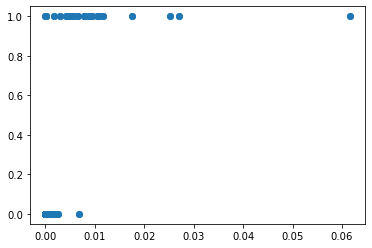

In [106]:
X,Y_true=DataLoader.load('mnist_5')

t1=time.time()
Y_pred,E_raw,V=api.DGSFC.fit(  X,
                  K_d=30,
                  K_s=30,
                  threshold=0.0078,
                  way='P_mid/V',
                  alpha=0,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )

t2=time.time()
print(t2-t1)
print(measures_calculator(Y_true,Y_pred))

labels,edges = eval_edges(Y_pred,Y_true,E_raw)
plt.scatter(edges['v'],edges['pos'])

In [5]:
X,Y_true=DataLoader.load('mnist_5')

t1=time.time()
Y_pred=api.DGSFC.fit(  X,
                  K_d=55,
                  K_s=27,
                  alpha=0.2,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )

t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.5937645435333252


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.900795,0.799735,0.9012,0.810659,1.0,10.0


0.9473040103912354
        f1      ARI     ACC       NMI  cover_rate  classes
0  0.84227  0.72383  0.8339  0.785539         1.0     11.0


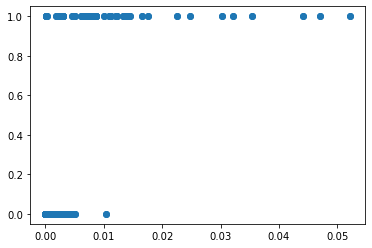

In [115]:
X,Y_true=DataLoader.load('mnist_10')

t1=time.time()
Y_pred,E_raw,V=api.DGSFC.fit(  X,
                  K_d=30,
                  K_s=30,
                  threshold=0.006,
                  way='P_mid/V',
                  alpha=0.2,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )
t2=time.time()
print(t2-t1)
print(measures_calculator(Y_true,Y_pred))

labels,edges = eval_edges(Y_pred,Y_true,E_raw)
plt.scatter(edges['v'],edges['pos'])

In [9]:
X,Y_true=DataLoader.load('mnist_10')

t1=time.time()
Y_pred=api.DGSFC.fit(  X,
                  K_d=45,
                  K_s=38,
                  alpha=0.2,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

1.435032606124878


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.874834,0.745218,0.8687,0.788179,1.0,11.0


In [59]:
X,Y_true=DataLoader.load('mnist_10')

t1=time.time()
Y_pred=api.DGSFC.fit(  X,
                  K_d=45,
                  K_s=37,
                  alpha=0.2,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

4.5527403354644775


,f1,ARI,ACC,cover_rate,classes
0,0.875953,0.747161,0.8698,1.0,11.0


In [6]:
X,Y_true=DataLoader.load('mnist_20')

t1=time.time()
Y_pred=api.DGSFC.fit(  X,
                  K_d=60,
                  K_s=30,
                  alpha=0.2,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

12.738249778747559


,f1,ARI,ACC,cover_rate,classes
0,0.820205,0.683836,0.8136,1.0,11.0


In [3]:
X,Y_true=DataLoader.load('mnist_30')

t1=time.time()
Y_pred,E_raw=api.DGSFC.fit(  X,
                  K_d=30,
                  K_s=30,
                  alpha=0.96,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

2.888607978820801


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.479922,0.432167,0.5135,0.592306,1.0,18.0


In [66]:
labels,edges = eval_edges(Y_pred,Y_true,E_raw)

In [63]:
edges['pos']

28     1.0
29     1.0
25     1.0
24     1.0
45     0.0
      ... 
793    0.0
867    0.0
866    0.0
849    0.0
848    0.0
Name: pos, Length: 868, dtype: float64

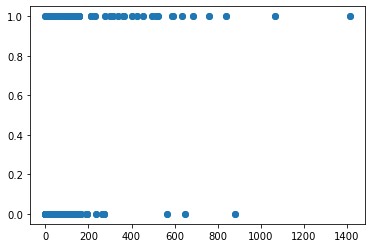

In [64]:
plt.scatter(edges['v'],edges['pos'])

(array([698.,  54.,  32.,  18.,  14.,   8.,   4.,   6.,   2.,   4.,   4.,
          2.,   6.,   4.,   2.,   0.,   2.,   2.,   2.,   0.,   0.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([1.18788830e-01, 4.72083505e+01, 9.42979123e+01, 1.41387474e+02,
        1.88477036e+02, 2.35566597e+02, 2.82656159e+02, 3.29745721e+02,
        3.76835283e+02, 4.23924844e+02, 4.71014406e+02, 5.18103968e+02,
        5.65193529e+02, 6.12283091e+02, 6.59372653e+02, 7.06462215e+02,
        7.53551776e+02, 8.00641338e+02, 8.47730900e+02, 8.94820461e+02,
        9.41910023e+02, 9.88999585e+02, 1.03608915e+03, 1.08317871e+03,
        1.13026827e+03, 1.17735783e+03, 1.22444739e+03, 1.27153696e+03,
        1.31862652e+03, 1.36571608e+03, 1.41280564e+03]),
 <BarContainer object of 30 artists>)

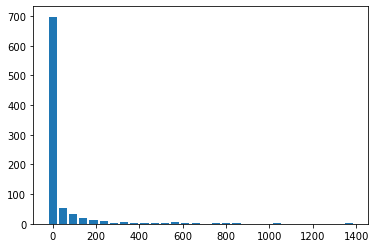

In [12]:
edges=list(E_raw.values())
plt.hist(edges, bins=30,  weights=None, cumulative=False, bottom=None,     
                histtype=u'bar', align=u'left', orientation=u'vertical',     
                rwidth=0.8, log=False, color=None, label=None, stacked=False) 

In [14]:
np.min(edges)

0.11878882990869342

In [12]:
X,Y_true=DataLoader.load('mnist_30')

t1=time.time()
Y_pred,E_raw,V=api.DGSFC.fit(  X,
                  K_d=25,
                  K_s=25,
                  threshold=6.922184459678946e-13,
                  way='P_mid/V',
                  alpha=0.2,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

2.8784947395324707


,f1,ARI,ACC,NMI,cover_rate,classes
0,0.528366,0.232254,0.4406,0.488141,1.0,38.0


In [7]:
X,Y_true=DataLoader.load('mnist_30')

t1=time.time()
Y_pred=api.DGSFC.fit(  X,
                  K_d=50,
                  K_s=25,
                  alpha=0.2,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

18.097525119781494


,f1,ARI,ACC,cover_rate,classes
0,0.809646,0.647999,0.7969,1.0,11.0


In [8]:
X,Y_true=DataLoader.load('fmnist_5')

t1=time.time()
Y_pred=api.DGSFC.fit(  X,
                  K_d=50,
                  K_s=30,
                  alpha=0.2,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )

t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

1.2313709259033203


,f1,ARI,ACC,cover_rate,classes
0,0.608804,0.476989,0.6255,1.0,11.0


In [9]:
X,Y_true=DataLoader.load('fmnist_10')

t1=time.time()
Y_pred=api.DGSFC.fit(  X,
                  K_d=60,
                  K_s=35,
                  alpha=0.3,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

3.931340217590332


,f1,ARI,ACC,cover_rate,classes
0,0.581473,0.42093,0.5626,1.0,14.0


In [10]:
X,Y_true=DataLoader.load('fmnist_20')

t1=time.time()
Y_pred=api.DGSFC.fit(  X,
                  K_d=65,
                  K_s=37,
                  alpha=0.3,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

13.259315490722656


,f1,ARI,ACC,cover_rate,classes
0,0.58313,0.440377,0.5762,1.0,11.0


In [11]:
X,Y_true=DataLoader.load('fmnist_30')

t1=time.time()
Y_pred=api.DGSFC.fit(  X,
                  K_d=75,
                  K_s=47,
                  alpha=0.4,
                  epsilon=0,
                  plot=False,
                  scale=True
                 )
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

24.979504823684692


,f1,ARI,ACC,cover_rate,classes
0,0.547136,0.398033,0.5731,1.0,11.0


# OPTICS

In [12]:
from sklearn.cluster import OPTICS

In [63]:
X,Y_true=DataLoader.load('mnist_5')
clustering = OPTICS(min_samples=5,min_cluster_size=2).fit(X)
Y_pred=clustering.labels_
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.186486,0.002716,0.219734,0.1429,11.0


In [64]:
X,Y_true=DataLoader.load('mnist_10')
clustering = OPTICS(min_samples=3,min_cluster_size=3).fit(X)
Y_pred=clustering.labels_
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.131752,0.002739,0.213478,0.2033,11.0


In [67]:
X,Y_true=DataLoader.load('mnist_20')
clustering = OPTICS(min_samples=3,min_cluster_size=3).fit(X)
Y_pred=clustering.labels_
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.147813,0.002626,0.236502,0.1704,11.0


In [68]:
X,Y_true=DataLoader.load('mnist_30')
clustering = OPTICS(min_samples=2,min_cluster_size=3).fit(X)
Y_pred=clustering.labels_
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.101455,0.001103,0.179644,0.2132,11.0


In [69]:
X,Y_true=DataLoader.load('fmnist_5')
clustering = OPTICS(min_samples=2,min_cluster_size=8).fit(X)
Y_pred=clustering.labels_
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.175558,0.009143,0.206633,0.1176,11.0


In [70]:
X,Y_true=DataLoader.load('fmnist_10')
clustering = OPTICS(min_samples=2,min_cluster_size=5).fit(X)
Y_pred=clustering.labels_
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.143594,0.001064,0.178141,0.1162,11.0


In [71]:
X,Y_true=DataLoader.load('fmnist_20')
clustering = OPTICS(min_samples=2,min_cluster_size=4).fit(X)
Y_pred=clustering.labels_
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.139953,0.001166,0.192058,0.1234,11.0


In [72]:
X,Y_true=DataLoader.load('fmnist_30')
clustering = OPTICS(min_samples=2,min_cluster_size=4).fit(X)
Y_pred=clustering.labels_
Y_pred,Y_true=matchY(Y_pred,Y_true)
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.129542,0.002689,0.178226,0.124,11.0


# DBSCAN

In [120]:
from sklearn.cluster import DBSCAN

In [121]:
X,Y_true=DataLoader.load('mnist_5')
t1=time.time()
dbscan = DBSCAN(eps=0.5).fit(X)
Y_pred = dbscan.labels_
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.09877419471740723


,f1,ARI,ACC,cover_rate,classes
0,0.838003,0.799491,0.818202,0.445,81.0


In [122]:
X,Y_true=DataLoader.load('mnist_10')
t1=time.time()
dbscan = DBSCAN(eps=1.2).fit(X)
Y_pred = dbscan.labels_
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.3859262466430664


,f1,ARI,ACC,cover_rate,classes
0,0.429318,0.322431,0.510239,0.4737,64.0


In [123]:
X,Y_true=DataLoader.load('mnist_20')
t1=time.time()
dbscan = DBSCAN(eps=2.).fit(X)
Y_pred = dbscan.labels_
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

1.3782236576080322


,f1,ARI,ACC,cover_rate,classes
0,0.366047,0.240276,0.468188,0.3725,50.0


In [124]:
X,Y_true=DataLoader.load('mnist_30')
t1=time.time()
dbscan = DBSCAN(eps=3.).fit(X)
Y_pred = dbscan.labels_
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

3.375020742416382


,f1,ARI,ACC,cover_rate,classes
0,0.442625,0.324856,0.532826,0.4859,47.0


In [125]:
X,Y_true=DataLoader.load('fmnist_5')
t1=time.time()
dbscan = DBSCAN(eps=0.5).fit(X)
Y_pred = dbscan.labels_
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.0974571704864502


,f1,ARI,ACC,cover_rate,classes
0,0.353891,0.298991,0.411071,0.3902,91.0


In [126]:
X,Y_true=DataLoader.load('fmnist_10')
t1=time.time()
dbscan = DBSCAN(eps=1.).fit(X)
Y_pred = dbscan.labels_
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.28125786781311035


,f1,ARI,ACC,cover_rate,classes
0,0.25444,0.258738,0.368629,0.3551,51.0


In [127]:
X,Y_true=DataLoader.load('fmnist_20')
t1=time.time()
dbscan = DBSCAN(eps=2.).fit(X)
Y_pred = dbscan.labels_
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.8694398403167725


,f1,ARI,ACC,cover_rate,classes
0,0.318221,0.293902,0.436594,0.3793,50.0


In [128]:
X,Y_true=DataLoader.load('fmnist_30')
t1=time.time()
dbscan = DBSCAN(eps=2.5).fit(X)
Y_pred = dbscan.labels_
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

1.8201045989990234


,f1,ARI,ACC,cover_rate,classes
0,0.206759,0.180837,0.329834,0.543,37.0


# HDBSCAN

In [73]:
import hdbscan

In [74]:
X,Y_true=DataLoader.load('mnist_5')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10,cluster_selection_epsilon=0.5)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

0.46245837211608887


,f1,ARI,ACC,cover_rate,classes
0,0.889706,0.900981,0.917821,0.4186,9.0


In [75]:
X,Y_true=DataLoader.load('mnist_10')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=1,cluster_selection_epsilon=0.1)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

2.0669567584991455


,f1,ARI,ACC,cover_rate,classes
0,0.849681,0.874101,0.860465,0.5418,15.0


In [76]:
X,Y_true=DataLoader.load('mnist_20')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=2,cluster_selection_epsilon=2)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

3.4372940063476562


,f1,ARI,ACC,cover_rate,classes
0,0.495667,0.356484,0.563065,0.4646,31.0


In [77]:
X,Y_true=DataLoader.load('mnist_30')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=1,cluster_selection_epsilon=2)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

7.433639764785767


,f1,ARI,ACC,cover_rate,classes
0,0.938794,0.936519,0.904397,0.4822,29.0


In [78]:
X,Y_true=DataLoader.load('fmnist_5')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=5,cluster_selection_epsilon=0.1)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

0.4517970085144043


,f1,ARI,ACC,cover_rate,classes
0,0.396973,0.313112,0.473973,0.365,13.0


In [79]:
X,Y_true=DataLoader.load('fmnist_10')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=1,cluster_selection_epsilon=0.1)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

1.0994291305541992


,f1,ARI,ACC,cover_rate,classes
0,0.147462,0.183848,0.27736,0.6789,7.0


In [80]:
X,Y_true=DataLoader.load('fmnist_20')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=45, min_samples=1,cluster_selection_epsilon=0.1)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

2.4263486862182617


,f1,ARI,ACC,cover_rate,classes
0,0.289571,0.255783,0.423558,0.4559,5.0


In [81]:
X,Y_true=DataLoader.load('fmnist_30')
t1=time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=1,cluster_selection_epsilon=0.1)
clusterer.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=clusterer.labels_

measures_calculator(Y_true, Y_pred)

4.384096384048462


,f1,ARI,ACC,cover_rate,classes
0,0.181833,0.153549,0.298925,0.6791,4.0


# mean-shift

In [82]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [83]:
X,Y_true=DataLoader.load('mnist_5')
bandwidth = estimate_bandwidth(X, quantile=0.01, n_samples=1000)
t1=time.time()
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=ms.labels_
measures_calculator(Y_true, Y_pred)

10.048216819763184


,f1,ARI,ACC,cover_rate,classes
0,0.790632,0.544347,0.7223,1.0,90.0


In [84]:
X,Y_true=DataLoader.load('mnist_10')
bandwidth = estimate_bandwidth(X, quantile=0.01, n_samples=1000)
t1=time.time()
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=ms.labels_
measures_calculator(Y_true, Y_pred)

23.72654128074646


,f1,ARI,ACC,cover_rate,classes
0,0.707042,0.561116,0.6707,1.0,40.0


In [85]:
X,Y_true=DataLoader.load('mnist_20')
bandwidth = estimate_bandwidth(X, quantile=0.01, n_samples=1000)
t1=time.time()
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=ms.labels_
measures_calculator(Y_true, Y_pred)

4.478219509124756


,f1,ARI,ACC,cover_rate,classes
0,0.512358,0.465628,0.5801,1.0,8.0


In [86]:
X,Y_true=DataLoader.load('mnist_30')
bandwidth = estimate_bandwidth(X, quantile=0.01, n_samples=1000)
t1=time.time()
ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True)
ms.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=ms.labels_
measures_calculator(Y_true, Y_pred)

186.4940218925476


,f1,ARI,ACC,cover_rate,classes
0,0.450197,0.31679,0.4463,1.0,75.0


In [87]:
X,Y_true=DataLoader.load('fmnist_5')
bandwidth = estimate_bandwidth(X, quantile=0.01, n_samples=1000)
t1=time.time()
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=ms.labels_
measures_calculator(Y_true, Y_pred)

12.42464017868042


,f1,ARI,ACC,cover_rate,classes
0,0.465823,0.296305,0.4371,1.0,62.0


In [88]:
X,Y_true=DataLoader.load('fmnist_10')
bandwidth = estimate_bandwidth(X, quantile=0.01, n_samples=1000)
t1=time.time()
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=ms.labels_
measures_calculator(Y_true, Y_pred)

27.08362364768982


,f1,ARI,ACC,cover_rate,classes
0,0.313768,0.242606,0.3291,1.0,80.0


In [89]:
X,Y_true=DataLoader.load('fmnist_20')
bandwidth = estimate_bandwidth(X, quantile=0.01, n_samples=1000)
t1=time.time()
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=ms.labels_
measures_calculator(Y_true, Y_pred)

3.6702380180358887


,f1,ARI,ACC,cover_rate,classes
0,0.316771,0.272929,0.3889,1.0,12.0


In [90]:
X,Y_true=DataLoader.load('fmnist_30')
bandwidth = estimate_bandwidth(X, quantile=0.01, n_samples=1000)
t1=time.time()
ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True)
ms.fit(X)
t2=time.time()
print(t2-t1)
Y_pred=ms.labels_
measures_calculator(Y_true, Y_pred)

156.93770217895508


,f1,ARI,ACC,cover_rate,classes
0,0.320346,0.221635,0.3261,1.0,171.0


# QuickshiftPP

In [100]:
from QuickshiftPP import *

/usr/data/software/anaconda3/envs/ML/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [101]:
X,Y_true=DataLoader.load('mnist_5')
t1=time.time()
model = QuickshiftPP(k=60,beta=0.4)
model.fit([X[i] for i in range(X.shape[0])])
Y_pred = model.memberships
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.47122979164123535


,f1,ARI,ACC,cover_rate,classes
0,0.788353,0.73518,0.8061,1.0,14.0


In [102]:
X,Y_true=DataLoader.load('mnist_10')
t1=time.time()
model = QuickshiftPP(k=50,beta=0.5)
model.fit([X[i] for i in range(X.shape[0])])
Y_pred = model.memberships
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.788964033126831


,f1,ARI,ACC,cover_rate,classes
0,0.661989,0.621624,0.7162,1.0,14.0


In [103]:
X,Y_true=DataLoader.load('mnist_20')
t1=time.time()
model = QuickshiftPP(k=50,beta=0.5)
model.fit([X[i] for i in range(X.shape[0])])
Y_pred = model.memberships
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

1.9896926879882812


,f1,ARI,ACC,cover_rate,classes
0,0.655562,0.637322,0.6858,1.0,20.0


In [104]:
X,Y_true=DataLoader.load('mnist_30')
t1=time.time()
model = QuickshiftPP(k=50,beta=0.5)
model.fit([X[i] for i in range(X.shape[0])])
Y_pred = model.memberships
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

3.1255416870117188


,f1,ARI,ACC,cover_rate,classes
0,0.644419,0.588566,0.6582,1.0,27.0


In [105]:
X,Y_true=DataLoader.load('fmnist_5')
t1=time.time()
model = QuickshiftPP(k=60,beta=0.05)
model.fit([X[i] for i in range(X.shape[0])])
Y_pred = model.memberships
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.4710526466369629


,f1,ARI,ACC,cover_rate,classes
0,0.558703,0.434594,0.5695,1.0,11.0


In [106]:
X,Y_true=DataLoader.load('fmnist_10')
t1=time.time()
model = QuickshiftPP(k=50,beta=0.1)
model.fit([X[i] for i in range(X.shape[0])])
Y_pred = model.memberships
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.6520452499389648


,f1,ARI,ACC,cover_rate,classes
0,0.511025,0.393695,0.5382,1.0,28.0


In [107]:
X,Y_true=DataLoader.load('fmnist_20')
t1=time.time()
model = QuickshiftPP(k=15,beta=0.7)
model.fit([X[i] for i in range(X.shape[0])])
Y_pred = model.memberships
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.9367737770080566


,f1,ARI,ACC,cover_rate,classes
0,0.485258,0.226145,0.4291,1.0,293.0


In [108]:
X,Y_true=DataLoader.load('fmnist_30')
t1=time.time()
model = QuickshiftPP(k=50,beta=0.6)
model.fit([X[i] for i in range(X.shape[0])])
Y_pred = model.memberships
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

2.164591073989868


,f1,ARI,ACC,cover_rate,classes
0,0.391266,0.247372,0.4427,1.0,59.0


# spectral

In [109]:
from sklearn.cluster import SpectralClustering

In [111]:
X,Y_true=DataLoader.load('mnist_5')
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.729294,0.703696,0.7785,1.0,10.0


In [113]:
X,Y_true=DataLoader.load('mnist_10')
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.709696,0.725195,0.7776,1.0,9.0


In [114]:
X,Y_true=DataLoader.load('mnist_20')
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.397106,0.350274,0.4994,1.0,9.0


In [115]:
X,Y_true=DataLoader.load('mnist_30')
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.142983,0.046773,0.2221,1.0,10.0


In [116]:
X,Y_true=DataLoader.load('fmnist_5')
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.57591,0.485648,0.619,1.0,10.0


In [117]:
X,Y_true=DataLoader.load('fmnist_10')
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.462424,0.439861,0.5406,1.0,10.0


In [118]:
X,Y_true=DataLoader.load('fmnist_20')
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.100142,0.152407,0.2155,1.0,10.0


In [119]:
X,Y_true=DataLoader.load('fmnist_30')
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0,
        affinity='rbf',#'nearest_neighbors','rbf'
#         n_neighbors=10
        ).fit(X)
Y_pred=clustering.labels_
result=measures_calculator(Y_true, Y_pred)
result

,f1,ARI,ACC,cover_rate,classes
0,0.143909,0.179427,0.2504,1.0,10.0


# k-means

In [91]:
from sklearn.cluster import KMeans

In [92]:
X,Y_true=DataLoader.load('mnist_5')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=5).fit(X)
Y_pred=kmeans.predict(X)
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.40067386627197266


,f1,ARI,ACC,cover_rate,classes
0,0.81237,0.673489,0.818,1.0,10.0


In [93]:
X,Y_true=DataLoader.load('mnist_10')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=5).fit(X)
Y_pred=kmeans.predict(X)
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.5293021202087402


,f1,ARI,ACC,cover_rate,classes
0,0.655667,0.569116,0.6622,1.0,10.0


In [94]:
X,Y_true=DataLoader.load('mnist_20')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=5).fit(X)
Y_pred=kmeans.predict(X)
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.4797844886779785


,f1,ARI,ACC,cover_rate,classes
0,0.529803,0.383411,0.5312,1.0,10.0


In [95]:
X,Y_true=DataLoader.load('mnist_30')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=5).fit(X)
Y_pred=kmeans.predict(X)
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.7523670196533203


,f1,ARI,ACC,cover_rate,classes
0,0.489717,0.346769,0.4874,1.0,10.0


In [96]:
X,Y_true=DataLoader.load('fmnist_5')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=5).fit(X)
Y_pred=kmeans.predict(X)
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.31171631813049316


,f1,ARI,ACC,cover_rate,classes
0,0.559114,0.4369,0.5691,1.0,10.0


In [97]:
X,Y_true=DataLoader.load('fmnist_10')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=5).fit(X)
Y_pred=kmeans.predict(X)
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.3285393714904785


,f1,ARI,ACC,cover_rate,classes
0,0.47962,0.386205,0.498,1.0,10.0


In [98]:
X,Y_true=DataLoader.load('fmnist_20')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=5).fit(X)
Y_pred=kmeans.predict(X)
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.3410024642944336


,f1,ARI,ACC,cover_rate,classes
0,0.479078,0.370895,0.5012,1.0,10.0


In [99]:
X,Y_true=DataLoader.load('fmnist_30')
t1=time.time()
kmeans = KMeans(n_clusters=10, random_state=5).fit(X)
Y_pred=kmeans.predict(X)
t2=time.time()
print(t2-t1)
measures_calculator(Y_true,Y_pred)

0.3666958808898926


,f1,ARI,ACC,cover_rate,classes
0,0.481848,0.360864,0.4976,1.0,10.0
